# U Net, MNIST dataset


### A tweak on the toy autoencoder


In [35]:
import os
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torchvision
from torchvision import transforms 
from torchvision.utils import save_image
import random
import math
from matplotlib import pyplot as plt

In [ ]:
num_epochs = 20
batch_size = 100
learning_rate = 0.001


In [37]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))])

#dataset for training (download = True to download the dataset for the first time)
train_dataset = torchvision.datasets.MNIST('mnist/',train=True,transform=transform, download=False)
#loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#dataset for testing (download = True to download the dataset for the first time)
test_dataset = torchvision.datasets.MNIST('mnist/',train=False,transform=transform, download=False)
#loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Class definition

In [75]:
#calculating the sizes of the feature maps for the contracting and expansive paths 

def o_downconv(i, k, s, p = 0):
    o = math.floor( (i + 2*p - k)/s ) + 1
    return o

def o_upconv(i, k, s, p = 0):
    o = (i-1)*s + k - 2*p
    return o


i = 28
d_16 = o_downconv( i, 5, 2)
d_32 = o_downconv( d_16, 5, 2)
latent = o_downconv( d_32, 3, 2)

print('{}\n{}\n{}\n\n{}\n'.format(i, d_16, d_32, latent) )

u_32 = o_upconv(latent, 4, 2)
u_16 = o_upconv (u_32, 6, 2)
o = o_upconv(u_16, 6, 2)

print('{}\n{}\n{}'.format(u_32, u_16, o) )



28
12
4

1

4
12
28


In [42]:
class UNet(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_1 = nn.Sequential(
            nn.Conv2d(1,16, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.enc_2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc_3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.dec_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2),
            nn.ReLU()
        )
        
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 16, kernel_size = 6, stride = 2),
            nn.ReLU()
        )       
        
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(16 + 16, 1, kernel_size = 6, stride = 2),
            nn.Tanh()
            #nn.ReLU()
        )        

    def forward(self, x):
        #downconvolutions
        out = self.enc_1(x)
        down_16 = out.clone()
        
        out = self.enc_2(out)
        down_32 = out.clone()
        
        #code
        out = self.enc_3(out)
        
        #upconvolutions
        out = self.dec_1(out)
        up_32_32 = torch.cat((out, down_32), 1)
        out = self.dec_2(up_32_32)
        up_16_16= torch.cat((out, down_16),1)
        out = self.dec_3(up_16_16)
        return out        

## Instantiation, training and saving the model

In [43]:
model = UNet()
criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss() #instead of BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


#denormalize the image
def denorm(x):
    out = x*0.5 + 0.5
    return out.clamp(0, 1)

#train
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        #backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), 'toy_unet.pkl')  

## Loading  a model and comparing results:

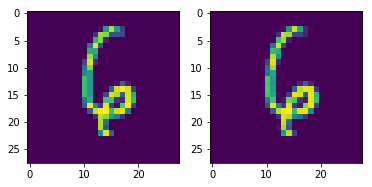

In [64]:
#loading
model_test = UNet()
model_test.load_state_dict(torch.load('toy_unet.pkl'))

#autoencode a random image from the test dataset
model_test.eval()
test_image = random.choice(test_dataset)
test_reconst = model_test((test_image[0].unsqueeze_(0)))

#plotting (left = test_image ; right = test_reconst)
fig, axs = plt.subplots(1, 2)
axs[0].imshow( test_image[0][0][0])
axs[1].imshow( test_reconst[0][0].detach().numpy())
plt.show()
